## NHD Network Analysis Demo
___TL;DR___: *We are trying to parallelize hydraulic calculations for dynamic subsets of the U.S. river and stream network*<br><br>
The following was developed as part of the process of preparing a method for forecasting flows on the US network of rivers and streams as represented in the National Hydrography Dataset (NHD). The NHD is a continuously evolving characterization of a fractal system so we felt that we needed to plan to have some flexibility. We hope to identify the complexity inherent in the network at different levels of resolution and we hope to be able to do so dynamically. The goal is also to be able to manage the complexity calculation for arbitrary collections of headwater points, such as might be obtained from a list of named streams or during a major flood event in a particular region.<br>
As a point of terminology, we use the word 'routing' as shorthand to refer to the computation of the translation of a particular flow condition, high or low, to downstream (or in some cases upstream) areas of influence.
The network complexity is related to the potential for parallelization of a serial analysis of the network. We have identified three levels of parallelization that may be implemented: 
1. Network-level parallelization of independent systems -- the routing computations for the Mississippi River have little (nothing, except conceptual similarity and a shared existence on earth) to do with the computations for the Columbia river for any practical level of analysis.
1. System-level parallelization of interconnected reaches -- There is a need to consider the computations for adjacent branches within system of con-flowing streams, but with proper ordering, some of the computations may be considered in parallel. For example, the Illinois River headwaters and the Mississippi River headwaters are related within their broader Mississippi system, but a most of the routing calculations for those headwaters are pratically agnostic to one another.
1. Reach-level parallelization of the specific routing computation -- the numerical work of routing water downstream is a matrix computation and consists of exploring solutions to differential equations, all of which may potentially be examined in parallel, under the proper conditions and with suitable assumptions.<br>


### Import the git repo including test data
This humble* git repo is a branch of the national water model public repository hosted by UCAR. The UCAR repo is the basis for the WRF-Hydro model that is presently the modeling engine of the [US National Water Model.](https://water.noaa.gov/about/nwm)<br>

The network analysis code assumes that the downstream neighbor is identified in the table for each stream segment as is the case for the test datasets. 

*The humility is prompted by the realization that others have done similar work and may possibly have done it better. We are working on being more able to nimpbly respond to suggestions and opportunities for improvement. Please let us know if you see something (and be patient if you don't feel like we heard you.)

In [0]:
# !pip install tensorflow  # or tensorflow-gpu
# !pip install ray[rllib]  # also recommended: ray[debug]
# !pip uninstall -y pyarrow
print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q ray[debug]

# A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash (this is not an issue).")
import os
os._exit(0)

Setting up colab environment
     |████████████████████████████████| 74.3MB 57kB/s 
     |████████████████████████████████| 71kB 8.9MB/s 
     |████████████████████████████████| 2.8MB 50.1MB/s 


##### Turn Autosave off
Autosave generates additional work for the version control. Remember to manually save any chances after clearing kernel and output for more effective version control.

In [0]:
%autosave 0 

##### Google Colab execution
Using this Chrome extension, the github-hosted jupyter notebooks may be opened directly in Google Colaboratory
https://chrome.google.com/webstore/detail/open-in-colab/iogfkhleblhcpcekbiedikdehleodpjo
more info here:
https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb

The following two StackOverflow posts helped with managing the dependencies
https://stackoverflow.com/questions/53581278/test-if-notebook-is-running-on-google-colab
https://stackoverflow.com/questions/53793731/using-custom-packages-on-google-colaboratory

[![Open This Notebook In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jameshalgren/wrf_hydro_nwm_public/blob/dynamic_channel_routing/trunk/NDHMS/dynamic_channel_routing/notebooks/NHD_Network_Density_Analysis.ipynb)

### Create some general functions
The next three blocks define interaction with the `networkbuilder` module in the git repo, which is the tool for creating the `connnections` object to characterize the network. 

In [0]:
import sys
try:
    import google.colab
    ENV_IS_CL = True
    !git clone --single-branch --branch network https://github.com/jameshalgren/wrf_hydro_nwm_public.git
    sys.path.append('/content/wrf_hydro_nwm_public/trunk/NDHMS/dynamic_channel_routing/src')
    !pip install geopandas
except:
    ENV_IS_CL = False
    sys.path.append(r'../src')


Cloning into 'wrf_hydro_nwm_public'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 16079 (delta 0), reused 1 (delta 0), pack-reused 16078
Receiving objects: 100% (16079/16079), 87.45 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (10235/10235), done.
Checking out files: 100% (594/594), done.
     |████████████████████████████████| 921kB 2.9MB/s 
     |████████████████████████████████| 10.1MB 16.1MB/s 
     |████████████████████████████████| 11.8MB 54.6MB/s 


In [0]:
import networkbuilder as networkbuilder
import recursive_print
import os
import geopandas as gpd
# -*- coding: utf-8 -*-
"""NHD Network traversal

A demonstration version of this code is stored in this Colaboratory notebook:
https://colab.research.google.com/github/jameshalgren/wrf_hydro_nwm_public/blob/network/trunk/NDHMS/dynamic_channel_routing/notebooks/NHD_Network_Density_Analysis.ipynb#scrollTo=h_BEdl4LID34

"""
def do_network(
        geofile_path = None
        , title_string = None
        , layer_string = None
        , driver_string = None
        , key_col = None
        , downstream_col = None
        , length_col = None
        , terminal_code = None
        , verbose = False
        , debuglevel = 0
        ):

    # NOTE: these methods can lose the "connections" and "rows" arguments when
    # implemented as class methods where those arrays are members of the class.
    if verbose: print(title_string)
    if debuglevel <= -1: print(f'reading -- dataset: {geofile_path}; layer: {layer_string}; fiona driver: {driver_string}')
    geofile = gpd.read_file(geofile_path, driver=driver_string, layer=layer_string)
    if debuglevel <= -1: print(geofile.head())
    geofile_rows = geofile.to_numpy()
    if debuglevel <= -1: geofile.plot()
    # Kick off recursive call for all connections and keys
    (connections) = networkbuilder.get_down_connections(
                    rows = geofile_rows
                    , key_col = key_col
                    , downstream_col = downstream_col
                    , length_col = length_col
                    , verbose = verbose
                    , debuglevel = debuglevel)
    
    (all_keys, ref_keys, headwater_keys
        , terminal_keys
        , terminal_ref_keys
        , circular_keys) = networkbuilder.determine_keys(
                    connections = connections
                    , rows = geofile_rows
                    , key_col = key_col
                    , downstream_col = downstream_col
                    , terminal_code = terminal_code
                    , verbose = verbose
                    , debuglevel = debuglevel)
    
    (junction_keys) = networkbuilder.get_up_connections(
                    connections = connections
                    , terminal_code = terminal_code
                    , headwater_keys = headwater_keys
                    , terminal_keys = terminal_keys
                    , verbose = verbose
                    , debuglevel = debuglevel)
    return connections, all_keys, ref_keys, headwater_keys \
        , terminal_keys, terminal_ref_keys \
        , circular_keys, junction_keys

In [0]:
def do_print():    
    recursive_print.print_basic_network_info(
                    connections = connections_NHD
                    , headwater_keys = headwater_keys_NHD
                    , junction_keys = junction_keys_NHD
                    , terminal_keys = terminal_keys_NHD
                    , terminal_code = terminal_code_NHD
                    , verbose = True
                    )
    
    if 1 == 0: #THE RECURSIVE PRINT IS NOT A GOOD IDEA WITH LARGE NETWORKS!!!
        recursive_print.print_connections(
                    headwater_keys = headwater_keys_NHD
                    , down_connections = connections_NHD
                    , up_connections = connections_NHD
                    , terminal_code = terminal_code_NHD
                    , terminal_keys = terminal_keys_NHD
                    , terminal_ref_keys = terminal_ref_keys_NHD
                    , debuglevel = -2
                    )
    


### Two Real Networks


CONUS Order 5 and Greater 
reading -- dataset: /content/wrf_hydro_nwm_public/trunk/NDHMS/dynamic_channel_routing/test/input/geo/Channels/NHD_Conus_Channels.shp; layer: 0; fiona driver: ESRI Shapefile
   OBJECTID  ...                                           geometry
0      2283  ...  LINESTRING (-99.43063 27.13471, -99.43124 27.1...
1      2284  ...  LINESTRING (-99.43195 27.08172, -99.43532 27.0...
2      2287  ...  LINESTRING (-99.39823 27.00032, -99.39863 26.9...
3      2290  ...  LINESTRING (-98.26538 26.11741, -98.26544 26.1...
4      2291  ...  LINESTRING (-98.30100 26.10593, -98.30102 26.1...

[5 rows x 23 columns]
down connections ...
found 171887 segments
down_connections complete
ref_keys ...
found 169383 ref_keys
ref_keys complete
headwater_keys ...
found 2505 headwater segments
headwater_keys complete
terminal_keys ...
found 355 terminal segments
of those, 0 had non-standard terminal keys
terminal_keys complete
circular_keys ...
identified at least 0 segments with circular

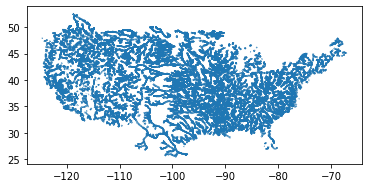

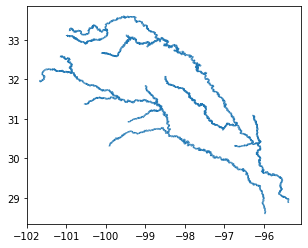

In [0]:
if ENV_IS_CL: root = '/content/wrf_hydro_nwm_public/trunk/NDHMS/dynamic_channel_routing/'
elif not ENGV_IS_CL: root = os.path.dirname(os.path.abspath(''))
test_folder = os.path.join(root, r'test')
geo_input_folder = os.path.join(test_folder, r'input', r'geo', r'Channels')

"""##NHD CONUS order 5 and greater"""
CONUS_ge5 = True
"""##NHD Subset (Brazos/Lower Colorado)"""
Brazos_LowerColorado_ge5 = True
CONUS_FULL_RES = False

debuglevel = -1
verbose = True

# The following datasets are extracts from the feature datasets available
# from https://www.nohrsc.noaa.gov/pub/staff/keicher/NWM_live/web/data_tools/
# the CONUS_ge5 and Brazos_LowerColorado_ge5 datasets are included
# in the github test folder

if CONUS_ge5:
    nhd_conus_file_path = os.path.join(geo_input_folder
            , r'NHD_Conus_Channels.shp')
    key_col_NHD = 1
    downstream_col_NHD = 6
    length_col_NHD = 5
    terminal_code_NHD = 0
    title_string = 'CONUS Order 5 and Greater '
    driver_string = 'ESRI Shapefile'
    layer_string = 0

    CONUS_ge5_values = do_network (nhd_conus_file_path
                , title_string = title_string
                , layer_string = layer_string
                , driver_string = driver_string
                , key_col = key_col_NHD
                , downstream_col = downstream_col_NHD
                , length_col = length_col_NHD
                , terminal_code = terminal_code_NHD
                , verbose = verbose
                , debuglevel = debuglevel)
    

if CONUS_FULL_RES:
    nhd_conus_file_path = '../../../../../../GISTemp/nwm_v12.gdb'
    key_col_NHD = 0
    downstream_col_NHD = 5
    length_col_NHD = 4
    terminal_code_NHD = 0
    title_string = 'CONUS Full Resolution NWM v1.2'
    driver_string = 'FileGDB'
    layer_string = 'channels_nwm_v12_routeLink'

    do_network (nhd_conus_file_path
                , title_string = title_string
                , layer_string = layer_string
                , driver_string = driver_string
                , key_col = key_col_NHD
                , downstream_col = downstream_col_NHD
                , length_col = length_col_NHD
                , terminal_code = terminal_code_NHD
                , verbose = verbose
                , debuglevel = debuglevel)

if Brazos_LowerColorado_ge5:
    nhd_conus_file_path = os.path.join(geo_input_folder
            , r'NHD_BrazosLowerColorado_Channels.shp')
    key_col_NHD = 2
    downstream_col_NHD = 7
    length_col_NHD = 6
    terminal_code_NHD = 0
    title_string = 'Brazos + Lower Colorado\nNHD stream orders 5 and greater\n'
    title_string = 'CONUS Order 5 and Greater '
    driver_string = 'ESRI Shapefile'
    layer_string = 0

    Brazos_LowerColorado_ge5_values = do_network (nhd_conus_file_path
                , title_string = title_string
                , layer_string = layer_string
                , driver_string = driver_string
                , key_col = key_col_NHD
                , downstream_col = downstream_col_NHD
                , length_col = length_col_NHD
                , terminal_code = terminal_code_NHD
                , verbose = verbose
                , debuglevel = debuglevel)
    
    



In [0]:
import recursive_print

def get_down_connections(rows, key_col, downstream_col
            , length_col
            , verbose = False, debuglevel = 0):
    if debuglevel <= -100: breakpoint()
    if verbose: print('down connections ...')
    connections = {row[key_col]: { 'data': row
                        , 'visited': False
                        , 'downstream': row[downstream_col]
                        , 'length': row[length_col]}
                                for row in rows}
    if debuglevel <= -1: print(f'found {len(connections.keys())} segments')
    if debuglevel <= -2: print(connections)
    if verbose: print('down_connections complete')

    #TODO: Change this function to operate only on Connection object
    return connections

def determine_keys(connections, rows
            , key_col, downstream_col
            , terminal_code
            , verbose = False, debuglevel = 0):
    if verbose: print('ref_keys ...')
    ref_keys = {row[downstream_col] for row in rows}
    if debuglevel <= -1: print(f'found {len(ref_keys)} ref_keys')
    if debuglevel <= -2: print(ref_keys)
    if verbose: print('ref_keys complete')
    if debuglevel <= -2: print(ref_keys)
    if verbose: print('headwater_keys ...')
    headwater_keys = {x for x in connections.keys() if x not in ref_keys}
    if debuglevel <= -1: print(f'found {len(headwater_keys)} headwater segments')
    if debuglevel <= -2: print(headwater_keys)
    if verbose: print('headwater_keys complete')

    # Get the downstream terminating nodes
    if verbose: print('terminal_keys ...')
    # Find the pointing-to keys not found in the key dataset.
    terminal_ref_keys = {x for x in ref_keys if x not in connections.keys()} # TODO: Determine if this is a set

    # Then collect the keys associated with those 'pointing-tos'
    terminal_keys = set()
    for row in rows:
        curr_term_ref_key = row[downstream_col]
        if curr_term_ref_key in terminal_ref_keys:
            if curr_term_ref_key != terminal_code:
                if debuglevel <= -2:
                    print(f'Non-standard terminal key {row[downstream_col]} found in segment {row[key_col]}')
            elif curr_term_ref_key == terminal_code:
                if debuglevel <= -2:
                    print(f'Standard terminal key {row[downstream_col]} found in segment {row[key_col]}')
            terminal_keys.add(row[key_col])
    if debuglevel <= -1: print(f'found {len(terminal_keys)} terminal segments')
    if debuglevel <= -1: print(f'of those, {len([x for x in terminal_ref_keys if x != terminal_code])} had non-standard terminal keys')
    if debuglevel <= -2: print(terminal_keys)
    if verbose: print('terminal_keys complete')

    if verbose: print('circular_keys ...')
    circular_keys = set()
    for key, value in connections.items():
        try:
        #TODO: benchmark try/except vs. nested if statment on 'in' to handle terminal keys
        # e.g., "if key not in terminal_keys: ... etc.
            if connections[connections[key]['downstream']]['downstream'] == key:
                circular_keys.add(key)
            elif connections[connections[connections[key]['downstream']]['downstream']]['downstream'] == key:
                circular_keys.add(key)
            elif connections[connections[connections[connections[key]['downstream']]['downstream']]['downstream']]['downstream'] == key:
                circular_keys.add(key)
            elif connections[connections[connections[connections[connections[key]['downstream']]['downstream']]['downstream']]['downstream']]['downstream'] == key:
                circular_keys.add(key)
        except: pass

    if debuglevel <= -1: print(f'identified at least {len(circular_keys)} segments with circular references testing to the fourth level')
    if debuglevel <= -2: print(circular_keys)
    if verbose: print('circular_keys complete')


    return connections.keys(), ref_keys, headwater_keys \
                , terminal_keys, terminal_ref_keys, circular_keys

def get_up_connections(connections
                    , terminal_code
                    , headwater_keys
                    , terminal_keys
                    , verbose = False, debuglevel = 0):

    # Create inverse of connections looking upstream
    if verbose: print('identifying upstream connections and junctions ...')

    # Using Sets for Junction and Visited keys is REALLY, REALLY, REALLY, FAST!!!
    junction_keys = set()
    visited_keys = set()
    junction_count = 0
    for hkey in headwater_keys:
        # TODO: Find the terminal segment for this headwater
        # TODO: and label all connections with their terminal segment.

        # Start with the headwater keys and label the upstream connections
        # with the terminal_code...
        # connections[hkey].update({'upstreams' : [terminal_code]})
        connections[hkey].update({'upstreams' : {terminal_code}})
        visited_keys.add(hkey)
        # Then iterate through the list and search for the other values
        ukey = hkey
        # print(ukey, hkey)
        # print(visited_keys)
        # print(ukey not in terminal_keys)
        # print(ukey not in junction_keys)
        while (ukey not in terminal_keys) and (ukey not in junction_keys):
            dkey = connections[ukey]['downstream']
            if 'upstreams' not in connections[dkey]: # Check for key in dictionary https://able.bio/rhett/check-if-a-key-exists-in-a-python-dictionary--73iajoz
                # connections[dkey].update({'upstreams': []}) #TODO: Consider making this a set/hash for the unusual possibility of many upstream segments
                connections[dkey].update({'upstreams': set()}) #TODO: Consider making this a set/hash for the unusual possibility of many upstream segments
                visited_keys.add(dkey)
                # connections[dkey]['upstreams'].append(ukey)
                connections[dkey]['upstreams'].add(ukey)
            else:
                if terminal_code in connections[dkey]['upstreams']:
                    # If the downstream node here is labeled as a headwater (because it
                    # has an upstream set with the terminal code), it means
                    # that the network had a break and that the traversal has
                    # spanned the gap and the headwater is not actually not a terminating node.
                    # In that case, reset the node to be a blank set, then proceed downstream.
                    # THIS IS A DANGEROUS STEP AND DESERVES ADDITIONAL REVIEW
                    connections[dkey].update({'upstreams' : set()})
                connections[dkey]['upstreams'].add(ukey)
                # print(dkey, connections[dkey]['upstreams'], visited_keys)
                if len(connections[dkey]['upstreams'])  == 2:
                    # breakpoint()
                    if dkey not in junction_keys:
                        junction_keys.add(dkey)
                        # visited_keys.add(dkey)
                    if debuglevel <= -2: print (f"Junction found above/into Segment {dkey} with upstream Segments {connections[dkey]['upstreams']}")
                    junction_count += 1
                elif len(connections[dkey]['upstreams']) > 2:
                    if dkey not in junction_keys:
                        #At this point, the logic does not allow for this to be a non-junction
                        #TODO: raise/handle error/warning
                        print('key error -- junction analysis has an undetermined anomaly!')
                    if debuglevel <= -2: print (f"revisited Junction above/into Segment {dkey} now with upstream Segments {connections[dkey]['upstreams']}")
                    junction_count += 1
            ukey = dkey
        # if len(visited_keys) > 14266: breakpoint()

    if debuglevel <= -1: print(f'visited {len(visited_keys)} segments')
    if debuglevel <= -1: print(f'found {junction_count} junctions in {len(junction_keys)} junction nodes')
    if debuglevel <= -2: print(junction_keys)
    if debuglevel <= -2: print(connections)
    if verbose: print('up_connections complete')
    if verbose: print('')

    return junction_keys

def main():
    """##TEST"""
    print("")
    print ('Executing Test')
    # Test data
    test_rows = [
    [0,456,None,0],
    [1,678,4,0],
    [2,394,0,0],
    [3,815,2,0],
    [4,798,0,0],
    [5,679,4,0],
    [6,394,0,0],
    [7,815,2,0],
    [8,841,None,0],
    [9,524,12,0],
    [10,458,9,0],
    [11,548,8,0],
    [12,543,8,0],
    [13,458,14,0],
    [14,548,10,0],
    [15,543,14,0],
]

    test_key_col = 0
    test_downstream_col = 2
    test_length_col = 1
    test_terminal_code = -999

    (test_connections) = networkbuilder.get_down_connections(
                rows = test_rows
                , key_col = test_key_col
                , downstream_col = test_downstream_col
                , length_col = test_length_col
                , verbose = True
                , debuglevel = -2
                )

    (test_all_keys, test_ref_keys, test_headwater_keys
     , test_terminal_keys
     , test_terminal_ref_keys
     , test_circular_keys) = networkbuilder.determine_keys(
                connections = test_connections
                , rows = test_rows
                , key_col = test_key_col
                , downstream_col = test_downstream_col
                , terminal_code = test_terminal_code
                , verbose = True
                , debuglevel = -2
                )

    test_junction_keys = networkbuilder.get_up_connections(
                connections = test_connections
                , terminal_code = test_terminal_code
                , headwater_keys = test_headwater_keys
                , terminal_keys = test_terminal_keys
                , verbose = True
                , debuglevel = -2
                )

    recursive_print.print_connections(
                headwater_keys = test_headwater_keys
                , down_connections = test_connections
                , up_connections = test_connections
                , terminal_code = test_terminal_code
                , terminal_keys = test_terminal_keys
                , terminal_ref_keys = test_terminal_ref_keys
                , debuglevel = -2
                )

    recursive_print.print_basic_network_info(
                connections = test_connections
                , headwater_keys = test_headwater_keys
                , junction_keys = test_junction_keys
                , terminal_keys = test_terminal_keys
                , terminal_code = test_terminal_code
                , verbose = True
                , debuglevel = -2
                )

if __name__ == '__main__':
    main()



Executing Test
down connections ...
found 16 segments
{0: {'data': [0, 456, None, 0], 'visited': False, 'downstream': None, 'length': 456}, 1: {'data': [1, 678, 4, 0], 'visited': False, 'downstream': 4, 'length': 678}, 2: {'data': [2, 394, 0, 0], 'visited': False, 'downstream': 0, 'length': 394}, 3: {'data': [3, 815, 2, 0], 'visited': False, 'downstream': 2, 'length': 815}, 4: {'data': [4, 798, 0, 0], 'visited': False, 'downstream': 0, 'length': 798}, 5: {'data': [5, 679, 4, 0], 'visited': False, 'downstream': 4, 'length': 679}, 6: {'data': [6, 394, 0, 0], 'visited': False, 'downstream': 0, 'length': 394}, 7: {'data': [7, 815, 2, 0], 'visited': False, 'downstream': 2, 'length': 815}, 8: {'data': [8, 841, None, 0], 'visited': False, 'downstream': None, 'length': 841}, 9: {'data': [9, 524, 12, 0], 'visited': False, 'downstream': 12, 'length': 524}, 10: {'data': [10, 458, 9, 0], 'visited': False, 'downstream': 9, 'length': 458}, 11: {'data': [11, 548, 8, 0], 'visited': False, 'downstream

###Build a test case
The `test_rows` object simulates a river network dataset such as we recieve from the National Hydrography Dataset. Each data row has a node ID, a 'to' node ID, and some other relevant data. For this test dataset, the second data column is a dummy length (and the last column could be some other value, but we haven't tried anything yet... stay tuned) and in our traversals, we can add up the lengths as a surrogate for more complex water routing functions we need to eventually manage.

In [0]:
# def main():
if 1 == 1:
    """##TEST"""
    print("")
    print ('Executing Test')
    # Test data
    test_rows = [
    [0,456,None,0],
    [1,678,4,0],
    [2,394,0,0],
    [3,815,2,0],
    [4,798,0,0],
    [5,679,4,0],
    [6,394,0,0],
    [7,815,2,0],
    [8,841,None,0],
    [9,524,12,0],
    [10,458,9,0],
    [11,548,8,0],
    [12,543,8,0],
    [13,458,14,0],
    [14,548,10,0],
    [15,543,14,0],
]

    test_key_col = 0
    test_downstream_col = 2
    test_length_col = 1
    test_terminal_code = -999
    debuglevel = -2
    verbose = True

    (test_connections) = networkbuilder.get_down_connections(
                rows = test_rows
                , key_col = test_key_col
                , downstream_col = test_downstream_col
                , length_col = test_length_col
                , verbose = True
                , debuglevel = debuglevel
                )

    (test_all_keys, test_ref_keys, test_headwater_keys
     , test_terminal_keys
     , test_terminal_ref_keys
     , test_circular_keys) = networkbuilder.determine_keys(
                connections = test_connections
                , rows = test_rows
                , key_col = test_key_col
                , downstream_col = test_downstream_col
                , terminal_code = test_terminal_code
                , verbose = True
                , debuglevel = debuglevel
                )

    test_junction_keys = networkbuilder.get_up_connections(
                connections = test_connections
                , terminal_code = test_terminal_code
                , headwater_keys = test_headwater_keys
                , terminal_keys = test_terminal_keys
                , verbose = True
                , debuglevel = debuglevel
                )

    recursive_print.print_connections(
                headwater_keys = test_headwater_keys
                , down_connections = test_connections
                , up_connections = test_connections
                , terminal_code = test_terminal_code
                , terminal_keys = test_terminal_keys
                , terminal_ref_keys = test_terminal_ref_keys
                , debuglevel = debuglevel
                )

    recursive_print.print_basic_network_info(
                connections = test_connections
                , headwater_keys = test_headwater_keys
                , junction_keys = test_junction_keys
                , terminal_keys = test_terminal_keys
                , terminal_code = test_terminal_code
                , verbose = True
                , debuglevel = debuglevel
                )


# if __name__ == "__main__":
#     main()



Executing Test
down connections ...
found 16 segments
{0: {'data': [0, 456, None, 0], 'visited': False, 'downstream': None, 'length': 456}, 1: {'data': [1, 678, 4, 0], 'visited': False, 'downstream': 4, 'length': 678}, 2: {'data': [2, 394, 0, 0], 'visited': False, 'downstream': 0, 'length': 394}, 3: {'data': [3, 815, 2, 0], 'visited': False, 'downstream': 2, 'length': 815}, 4: {'data': [4, 798, 0, 0], 'visited': False, 'downstream': 0, 'length': 798}, 5: {'data': [5, 679, 4, 0], 'visited': False, 'downstream': 4, 'length': 679}, 6: {'data': [6, 394, 0, 0], 'visited': False, 'downstream': 0, 'length': 394}, 7: {'data': [7, 815, 2, 0], 'visited': False, 'downstream': 2, 'length': 815}, 8: {'data': [8, 841, None, 0], 'visited': False, 'downstream': None, 'length': 841}, 9: {'data': [9, 524, 12, 0], 'visited': False, 'downstream': 12, 'length': 524}, 10: {'data': [10, 458, 9, 0], 'visited': False, 'downstream': 9, 'length': 458}, 11: {'data': [11, 548, 8, 0], 'visited': False, 'downstream

# Recursive network builder with ordering
**Recursive functions capable of constructing the network from their given terminal, upstream, and downstream keys. **
*   Segments between nodes are tallied.
*   Junctions are outputted in junc_dict.
*   Each node is assigned a computational order for parallel processing 
    outputted in order_dict.
*   Inputted network keys (CONUS,BRAZOS,TEST) can be controlled under imports. 
*   IDs are passed to these functions from super_networks.items() to step through from the initial river outlets to the headwaters while labeling each order. 


---

    ignore the 0s that are printed from the exception
    run everything prior to this cell 



    
    


In [0]:
#original 
import time

#list of the different key sets
#
# terminal_keys = Brazos_LowerColorado_ge5_values[4] 
# circular_keys = Brazos_LowerColorado_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = Brazos_LowerColorado_ge5_values[0]
#
terminal_keys = CONUS_ge5_values[4] 
circular_keys = CONUS_ge5_values[6]
terminal_keys_super = terminal_keys - circular_keys
con = CONUS_ge5_values[0]
#
# terminal_keys_super = test_terminal_keys - test_circular_keys
# con = test_connections
terminal_code = test_terminal_code


#orders of everything for computation in dictionary format
order_dict={}
junc_dict={}
head_dict={}

def recursive_junction_read (keys, iterator, con, network, terminal_code, verbose = False, debuglevel = 0):
    # print(keys)
    for key in keys:
        result = 'node' + str(key)
        order_dict[result] = iterator
        
        ckey = key
        ukeys = con[key]['upstreams']
        # print(f"segs at ckey {ckey}: {network['segment_count']}")
        while not len(ukeys) >= 2 and not (ukeys == [terminal_code]):
            # the terminal code will indicate a headwater
            if debuglevel <= -2: print(ukeys)
            (ckey,) = ukeys
            ukeys = con[ckey]['upstreams']
            network['segment_count'] += 1
            # print(f"segs at ckey {ckey}: {network['segment_count']}")
            #adds ordering for all nodes
            result = 'node' + str(ckey)
            order_dict[result] = iterator
            
        if len(ukeys) >= 2:
            if debuglevel <= -1: print(f"junction found at {ckey} with upstreams {ukeys}")
            network['segment_count'] += 1
            # print(f"segs at ckey {ckey}: {network['segment_count']}")
            network['junction_count'] += 1 #the Terminal Segment
            #iterator adds 1 each iteration to provide a new order of computation for each junction section not each node or group of segments
            result_junc = 'junc' + str(key)
            junc_dict[result_junc] = iterator
            recursive_junction_read (ukeys, iterator+1, con, network, terminal_code, verbose, debuglevel)
        elif ukeys == [terminal_code]:
            # print(f"headwater found at {ckey}")
            network['segment_count'] += 1
            # print(f"segs at ckey {ckey}: {network['segment_count']}")
            #below adds headwaters to the headwater list
            result_head = 'head' + str(key)
            head_dict[result_head] = iterator
    
def super_network_trace(nid, iterator, con, network, terminal_code, debuglevel = 0):
    # print(f'\ntraversing upstream on network {nid}:')
    try:
        network.update({'junction_count': 0})
        network.update({'segment_count': 0}) #the Terminal Segment
        recursive_junction_read([nid], iterator , con, network, terminal_code, debuglevel = debuglevel)
        # print(f"junctions: {network['junction_count']}")
        # print(f"segments: {network['segment_count']}")
        
    except Exception as exc:
        print(exc)

super_networks = {terminal_key:{}
                        for terminal_key in terminal_keys_super}
debuglevel = 0

start_time = time.time()
for nid, network in super_networks.items():
    super_network_trace(nid, 0, con, network, terminal_code, debuglevel = debuglevel)
    
# print(con)
# print(super_networks)
print(network)
print("--- %s seconds ---" % (time.time() - start_time))
print(order_dict)
print(junc_dict)
print(head_dict)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
{'junction_count': 1, 'segment_count': 27}
--- 0.07097482681274414 seconds ---
{'node20331522': 0, 'node20331514': 0, 'node20331512': 0, 'node20331520': 0, 'node20331516': 0, 'node20332120': 0, 'node20331984': 0, 'node20331500': 0, 'node20331498': 0, 'node20331490': 0, 'node20331982': 0, '

###NOW for the next step
Once a 'connection' object has been created with a representation of the river network, we can traverse that object and perform calculations -- in the example below, we parallelize the process of traversing the independent portions of the network and then serially compute the number of junctions. We could compute total upstream length or [and this is the real goal] flow due to incoming lateral contributions from the land accumulated over the entire upstream network. That second calculation can also be parallelized but we have to figure out how to accomplish intelligently so that the collective calculation is network-aware. The upstream length will depend on the number of upstream branches and their configuration, so there has to be some concept of stream order and topology built into the parallelization method.

In [0]:

#parallel compute
import time
import multiprocessing

terminal_keys = CONUS_ge5_values[4] 
circular_keys = CONUS_ge5_values[6]
terminal_keys_super = terminal_keys - circular_keys
con = CONUS_ge5_values[0]
terminal_code = terminal_code_NHD
# terminal_keys = test_terminal_keys 
# circular_keys = test_circular_keys
# terminal_keys_super = terminal_keys - circular_keys
# con = test_connections
# teminal_code = test_terminal_code
# terminal_keys = Brazos_LowerColorado_ge5_values[4] 
# circular_keys = Brazos_LowerColorado_ge5_values[6]
# terminal_keys_super = terminal_keys - circular_keys
# con = Brazos_LowerColorado_ge5_values[0]
# terminal_code = terminal_code_NHD

super_networks = {terminal_key:{}
                        for terminal_key in terminal_keys_super}
debuglevel = 0
verbose = False

def recursive_junction_read (
                             keys
                             , network
                             , terminal_code = 0
                             , verbose = False
                             , debuglevel = 0
                            ):
    global con
    for key in keys:
        ckey = key
        ukeys = con[key]['upstreams']
        while not len(ukeys) >= 2 and not (ukeys == [terminal_code]):
            if debuglevel <= -2: print(f"segs at ckey {ckey}: {network['segment_count']}")
            # the terminal code will indicate a headwater
            if debuglevel <= -3: print(ukeys)
            (ckey,) = ukeys
            ukeys = con[ckey]['upstreams']
        if ukeys == [terminal_code]:
            if debuglevel <= -1: print(f"headwater found at {ckey}")
            network['segment_count'] += 1
            if debuglevel <= -2: print(f"segs at ckey {ckey}: {network['segment_count']}")
        elif len(ukeys) >= 2:
            network['segment_count'] += 1
            if debuglevel <= -1: print(f"junction found at {ckey} with upstreams {ukeys}")
            network['segment_count'] += 1
            if debuglevel <= -2: print(f"segs at ckey {ckey}: {network['segment_count']}")
            network['junction_count'] += 1 #the Terminal Segment
            recursive_junction_read (ukeys, network, verbose = verbose, debuglevel = debuglevel) 
            # print(ukeys)
            ukeys = con[ckey]['upstreams']
            ckey = ukeys

def super_network_trace(
                        nid
                        , verbose= False
                        , terminal_code = 0
                        , debuglevel = 0
                        ):

    network = {}
    global con
    
    if verbose: print(f'\ntraversing upstream on network {nid}:')
    # try:
    if 1 == 1:
        network.update({'junction_count': 0})
        network.update({'segment_count': 0}) #the Terminal Segment
        recursive_junction_read([nid], network, verbose = verbose, terminal_code = terminal_code, debuglevel = debuglevel)
        if verbose: print(f"junctions: {network['junction_count']}")
        if verbose: print(f"segments: {network['segment_count']}")
    # except Exception as exc:
    #     print(exc)
    return network


start_time = time.time()
results_serial = {}
for nid, network in super_networks.items():
    network.update({nid: super_network_trace(nid, verbose = verbose, debuglevel = debuglevel)})
    # super_network_trace(nid, con, network, terminal_code, debuglevel = debuglevel
print("--- %s seconds ---" % (time.time() - start_time))

print(super_networks.items())
print(len(super_networks.items()))
nids = (nid for nid in super_networks)
# networks = ((nid, network) for nid, network in super_networks.items())
start_time = time.time()
with multiprocessing.Pool() as pool:
    # results = pool.starmap(super_network_trace, [(nid, network) for nid, network in super_networks.items()])
    results = pool.map(super_network_trace, nids)
    # results = pool.starmap(super_network_trace, networks)
    print("--- %s seconds ---" % (time.time() - start_time))

print(results)


start_time = time.time()
results_serial = {}
for nid, network in super_networks.items():
    network.update({nid: super_network_trace(nid, verbose = verbose, debuglevel = debuglevel)})
    # super_network_trace(nid, con, network, terminal_code, debuglevel = debuglevel
print("--- %s seconds ---" % (time.time() - start_time))

print(super_networks.items())
print(len(super_networks.items()))
nids = (nid for nid in super_networks)
# networks = ((nid, network) for nid, network in super_networks.items())
start_time = time.time()
with multiprocessing.Pool() as pool:
    # results = pool.starmap(super_network_trace, [(nid, network) for nid, network in super_networks.items()])
    results = pool.map(super_network_trace, nids)
    # results = pool.starmap(super_network_trace, networks)
    print("--- %s seconds ---" % (time.time() - start_time))

print(results)


--- 0.11799454689025879 seconds ---
dict_items([(20331522, {20331522: {'junction_count': 0, 'segment_count': 1}}), (946060297, {946060297: {'junction_count': 0, 'segment_count': 1}}), (12186639, {12186639: {'junction_count': 0, 'segment_count': 1}}), (10850322, {10850322: {'junction_count': 3, 'segment_count': 10}}), (21412883, {21412883: {'junction_count': 181, 'segment_count': 544}}), (22823956, {22823956: {'junction_count': 0, 'segment_count': 1}}), (9455643, {9455643: {'junction_count': 0, 'segment_count': 1}}), (2297884, {2297884: {'junction_count': 22, 'segment_count': 67}}), (3396642, {3396642: {'junction_count': 0, 'segment_count': 1}}), (8272933, {8272933: {'junction_count': 0, 'segment_count': 1}}), (17159214, {17159214: {'junction_count': 1, 'segment_count': 4}}), (3712048, {3712048: {'junction_count': 2, 'segment_count': 7}}), (946060337, {946060337: {'junction_count': 0, 'segment_count': 1}}), (1797169, {1797169: {'junction_count': 0, 'segment_count': 1}}), (10694707, {106

In [0]:
|

SyntaxError: ignored